In [1]:
import numpy as np
import pandas as pd

from scipy.stats import linregress, powerlaw

import matplotlib.pyplot as plt
from matplotlib.patches import Patch
import seaborn as sns

## load data

In [2]:
df = pd.read_csv("/home/jovyan/shared/mahdi/1_projects/model_optimization/05loss_analysis/isodata.csv")
df = df[df["plottable"]]

In [3]:
dataset_map = {
    'full': 'F',
    'half': 'H',
    'quarter': 'Q'
}

In [4]:
df['dataset'] = df['dataset'].map(dataset_map)

## cross-entropy loss plot

In [5]:
datasets = df["dataset"].unique().tolist()
parameters = df["model_size"].unique().tolist()
parameters_labels = df["size_label"].unique().tolist()
palette = dict(zip(datasets[::-1],
                   sns.color_palette("colorblind", 3).as_hex()))

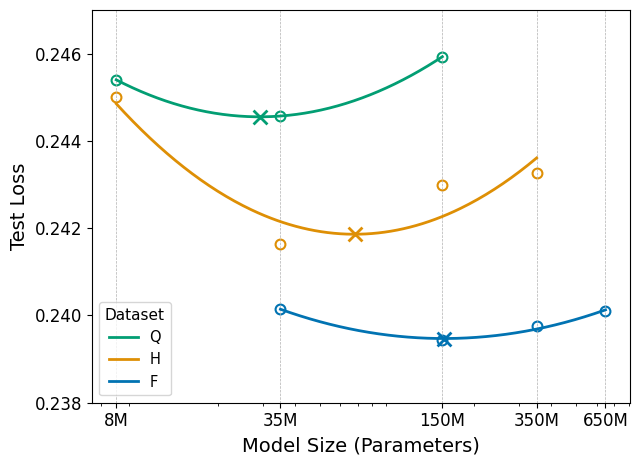

In [6]:
plt.figure(figsize=(6.5, 4.75))

optimal_sizes = []
for dataset in datasets:
    _df = df[df["dataset"] == dataset]
    losses = _df["loss"]
    params = _df["model_size"]
    log_params = np.log10(params)

    # quadratic fit
    coeffs = np.polyfit(log_params, losses, deg=2)
    a, b, c = coeffs
    poly = np.poly1d(coeffs)

    # find loss minimum
    logp_min = -b / (2 * a)
    params_min = 10**logp_min
    loss_min = poly(logp_min)
    optimal_sizes.append(int(params_min))

    # scatter plot
    plt.scatter(
        params, 
        losses,
        edgecolors=palette[dataset],
        linewidths=1.5,
        color="w",
        s=50,
    )

    # fit line
    smooth = np.linspace(log_params.min(), log_params.max(), 200)
    plt.plot(
        10**smooth, 
        poly(smooth),
        color=palette[dataset], 
        linewidth=2,
        label=dataset
    )

    # plot loss minimum
    plt.scatter(
        [params_min], 
        [loss_min],
        marker='x', 
        s=100, 
        linewidths=2,
        color=palette[dataset], 
        zorder=5,
    )

ax = plt.gca()

ax.set_xscale("log")
ax.set_ylim([0.238, 0.247])

plt.xticks(parameters, parameters_labels, fontsize=12)
plt.tick_params(axis='y', labelsize=12)

ax.set_xlabel("Model Size (Parameters)", fontsize=14)
ax.set_ylabel("Test Loss", fontsize=14)

# legend
plt.legend(fontsize=10.5, title="Dataset", title_fontsize=11, loc='lower left')
plt.grid(which="major", axis="x", linestyle="--", linewidth=0.5)

# save
plt.tight_layout()
plt.savefig("./figures/isodata_curves.png", bbox_inches='tight', dpi=300)

### extract info for regression

In [7]:
optimal_sizes

[29020563, 68099905, 152000061]

In [8]:
data_sizes = np.array([412182, 824363, 1648726])

In [9]:
# log regress for plot
log_model_sizes = np.log(optimal_sizes)
log_data_sizes = np.log(data_sizes)
regress_results = linregress(log_model_sizes, log_data_sizes)

slope_log, intercept_log, r_value, p_value, std_err_log = regress_results

In [10]:
np.exp(intercept_log) * (6.5e8**slope_log)

5523212.432712386

## regression plot

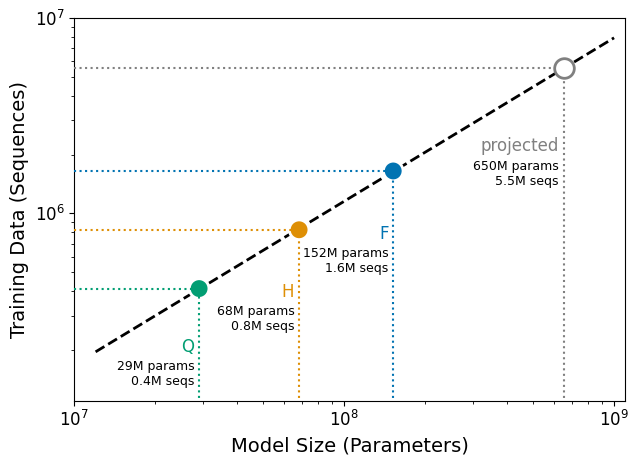

In [11]:
plt.figure(figsize=(6.5, 4.75))
colors = list(palette.values())[::-1]

# scatter plot
sns.scatterplot(
    x=optimal_sizes, 
    y=data_sizes, 
    s=200,
    color=colors,
    zorder=5, 
    legend=False,
    linewidths=2,
)

ax = plt.gca()

# plot regression line
fit_coeff = np.exp(intercept_log)
fit_exponent = slope_log
fit_xs = np.linspace(12e6, 1e9, 200)
fit_ys = fit_coeff * (fit_xs ** fit_exponent)
plt.plot(
    fit_xs, 
    fit_ys, 
    color="k", 
    linestyle="--", 
    lw=2,
    zorder=3,
)

# extrapolate to 650M param model
extrapolated_model_size = 6.5e8
extrapolated_data_size = fit_coeff * (extrapolated_model_size ** fit_exponent)
plt.scatter(
    x=[extrapolated_model_size], 
    y=[extrapolated_data_size], 
    s=200,
    edgecolors="gray",
    c="w",
    zorder=5, 
    linewidths=2,
)
plt.vlines(x=extrapolated_model_size, ymin=1e5, ymax=extrapolated_data_size, colors="gray", linestyles=":", linewidths=1.5, zorder=4)
plt.hlines(y=extrapolated_data_size, xmin=1e7, xmax=extrapolated_model_size, colors="gray", linestyles=":", linewidths=1.5, zorder=4)

# plot model/data reference lines
for ms, ds, c in zip(optimal_sizes, data_sizes, colors):
    plt.vlines(x=ms, ymin=1e5, ymax=ds, colors=c, linestyles=":", linewidths=1.5, zorder=6)
    plt.hlines(y=ds, xmin=1e7, xmax=ms, colors=c, linestyles=":", linewidths=1.5, zorder=6)

# text for optimal model sizes
short_param_labels = ["29M", "68M", "152M", "650M"]
short_data_labels = ["0.4M", "0.8M", "1.6M", "5.5M"]
short_model_labels = ["Q", "H", "F", "projected"]
all_data_sizes = list(data_sizes) + [5523212]
all_model_sizes = list(optimal_sizes) + [6.5e8]
all_colors = colors + ["grey"]

# add text
for param, data, model, x, y, c in zip(short_param_labels, short_data_labels, short_model_labels, all_model_sizes, all_data_sizes, all_colors):
    if model == "projected":
        ax.text(x=0.96*x, y=0.36*y, s=model, fontsize=12, horizontalalignment="right", verticalalignment="bottom", c=c)
        ax.text(x=0.96*x, y=0.34*y, s=f"{param} params\n{data} seqs", fontsize=9, horizontalalignment="right", verticalalignment="top")
    elif model == "Q":
        ax.text(x=0.96*x, y=0.45*y, s=model, fontsize=12, horizontalalignment="right", verticalalignment="bottom", c=c)
        ax.text(x=0.96*x, y=0.43*y, s=f"{param} params\n{data} seqs", fontsize=9, horizontalalignment="right", verticalalignment="top")
    else:
        ax.text(x=0.96*x, y=0.43*y, s=model, fontsize=12, horizontalalignment="right", verticalalignment="bottom", c=c)
        ax.text(x=0.96*x, y=0.41*y, s=f"{param} params\n{data} seqs", fontsize=9, horizontalalignment="right", verticalalignment="top")

ax = plt.gca()

ax.set_xscale('log')
ax.set_yscale('log')

ax.set_xlim([1e7, 1.1e9])
ax.set_ylim([1.1e5, 1e7])

ax.set_xlabel("Model Size (Parameters)", fontsize=14)
ax.set_ylabel("Training Data (Sequences)", fontsize=14)
ax.tick_params(axis="both", labelsize=12)

# save
plt.tight_layout()
plt.savefig("./figures/model-size_vs_data-scale.png", bbox_inches='tight', dpi=300)